Target accessible using at least 20.0 steps


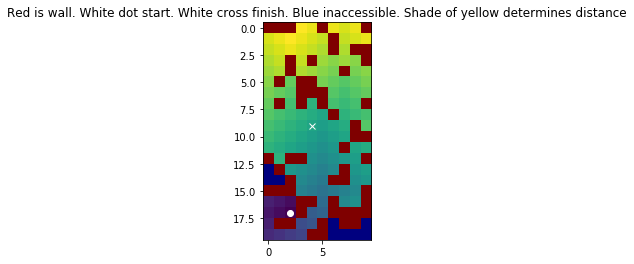

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

###########################
# Generate Labyrinth
###########################

probwall = 0.3
lab = np.random.uniform(0, 1, (20, 10)) < probwall
p0 = (
    np.random.randint(0, lab.shape[0]),
    np.random.randint(0, lab.shape[1]))
pf = (
    np.random.randint(0, lab.shape[0]),
    np.random.randint(0, lab.shape[1]))

# Source and target may not be walls
lab[p0] = 0
lab[pf] = 0

allowed_steps = [
    np.array([-1, 0]),
    np.array([1, 0]),
    np.array([0, -1]),
    np.array([0, 1])]

make_move = lambda p, step: tuple(np.array(p) + step)

###########################
# Check if target accessible using BFS
###########################
dist = np.nan * np.ones(lab.shape)
tasks = deque([(p0, 0)])

validmove = lambda p: (p[0]>=0)and(p[1]>=0)and(p[0]<lab.shape[0])and(p[1]<lab.shape[1])and(lab[p] == 0)

while len(tasks) > 0:
    p,d = tasks.popleft()
    if validmove(p) and np.isnan(dist[p]):
        dist[p] = d
        for step in allowed_steps:
            tasks.append((make_move(p, step), d+1))

if np.isnan(dist[pf]):
    print("Target inaccessible from source")
else:
    print("Target accessible using at least", dist[pf], "steps")
            
plt.figure()
plt.title("Red is wall. White dot start. White cross finish. Blue inaccessible. Shade of yellow determines distance")
plt.imshow(lab, cmap='jet')
plt.imshow(dist)
plt.plot([p0[1]], [p0[0]], 'o', color='white')
plt.plot([pf[1]], [pf[0]], 'x', color='white')
plt.show()

In [61]:
########################
# TD LEARNING
########################

# Constants
alpha = 0.1  # Learning rate
R0 = 1        # Max reward
gamma = 0.9   # Discount factor

# Value function - determines how good it is to be in each state
value = np.zeros(lab.shape)

# Policy - determines probability of choosing this state, given its value
def calc_p_move(pnew, pold):
    if not validmove(pnew):
        return 0
    elif pnew == pold:
        return np.exp(value[pnew])  # Strongly disincentivize walking backwards
    else:
        return np.exp(5*value[pnew])

# choose direction by softmax of values
def policy_move(p, pold):
    moves = [make_move(p, step) for step in allowed_steps]
    prob = np.array([calc_p_move(pnew, pold) for pnew in moves])
    prob /= np.sum(prob)
    moveidx = np.random.choice(4, p=prob)
    return moves[moveidx]

pold, p = p0, p0
reward_times = []
for iStep in range(50000):
    pnew = policy_move(p, pold)
    reward_this = R0 * int(p == pf)
    value[p] += alpha*(reward_this + gamma * value[pnew] - value[p])
    if reward_this > 0:
        reward_times += [iStep]
        pold, p = p0, p0
    else:
        pold, p = p, pnew

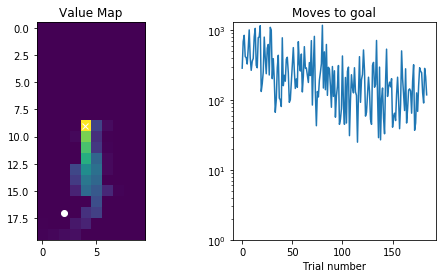

In [62]:
reward_delta = [reward_times[i] - reward_times[i-1] for i in range(1, len(reward_times))]

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].imshow(value)
ax[0].plot([p0[1]], [p0[0]], 'o', color='white')
ax[0].plot([pf[1]], [pf[0]], 'x', color='white')
ax[1].semilogy(reward_delta)
ax[1].set_ylim([1, 1.1*np.max(reward_delta)])
ax[0].set_title("Value Map")
ax[1].set_title("Moves to goal")
ax[1].set_xlabel("Trial number")
plt.show()